## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


**sc20ngh**

Your full name:

**Niall Horn**

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [1]:
# Std Imports
import math
import os

# Torch Imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader

# Misc Imports
import cv2
import numpy as np
from natsort import natsorted
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# ===== Get CUDA Device =====
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')
device_name = torch.cuda.get_device_name(0)
print("device = %s, using %s" % (device_name, device))

# ===== Util Functions =====

# Convert Pytorch Tensor to transposed numpy array to plot
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    return

device = NVIDIA GeForce RTX 3090, using cuda


## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [22]:
# TO COMPLETE
# Store dict of mapping from class label string, to class index
class_to_idx = {"baboon":0,"banana":1,"bee":2,"bison":3, "butterfly":4, "candle":5, "cardigan":6, "chihuahua":7, "elephant":8,
               "espresso":9, "fly":10, "goldfish":11, "goose":12, "grasshopper":13, "hourglass":14, "icecream":15, "ipod":16,
               "jellyfish":17, "koala":18, "ladybug":19, "lion":20, "mushroom":21, "penguin":22, "pig":23, "pizza":24, 
               "pretzel":25, "redpanda":26, "refrigerator":27, "sombrero":28, "umbrella":29}

# Dataset Loader for Training (and valid split)
class ImageLoader(torch.utils.data.Dataset):
    def __init__(self, dir, transform):
        self.dir = dir
        self.transform = transform
        # Walk directory recurrsivly store file location and parentdir (class label)
        imgs = []
        for root, dirs, files in os.walk(self.dir):
            for f in files:
                if '.JPEG' in f:
                    path = os.path.join(root, f) # Image Path 
                    label = os.path.basename(os.path.dirname(path)) # Parent Dir name
                    imgs.append((path, label))
        self.imgs = imgs
        return
    
    # Total image count (all classes)
    def __len__(self):
        return len(self.imgs)
    
    # Given an index, get a random image and its class 
    def __getitem__(self, idx):
        image, label = self.imgs[idx]
        class_idx =  class_to_idx[label]         # Map class label to index
        #print("%s | %s | %d" % (image, label, class_idx))
        image = Image.open(image).convert("RGB") # load image and perform transforms
        trans_image =  self.transform(image)     # Should be ToTensor() plus other transforms
        # Return output tensor and class index
        return trans_image, class_idx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Set Size = 10800 | Validation Set Size = 2700
Debug::Training Loader


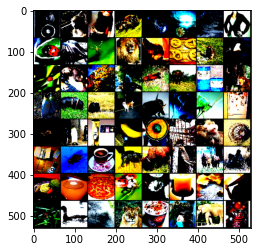

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Debug::Validation Loader


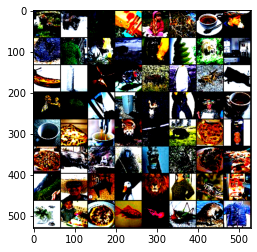

In [24]:
# ======== Create Datasets ========
# Define transform as ToTensor() and Normalization (-1 to 1)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

# Orginal Training Set
in_dataset = ImageLoader("_dataset\\train_set", transform=transform)
# Split into Training and Validation Set
train_size = int(0.8 * len(in_dataset))
valid_size = len(in_dataset) - train_size
print("Training Set Size = %d | Validation Set Size = %d" % (train_size, valid_size))
train_set, valid_set = torch.utils.data.random_split(in_dataset, [train_size, valid_size])

# DEBUG : Fetch random sample, get tensor component and convert to numpy array transposed, to display image
#image,label = train_set[1234]
#plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

# ======== Create DataLoaders ========
# Training, Validation Loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

# DEBUG : Show minibatch grid
print("Debug::Training Loader")
sample, label = iter(train_loader).next()  
timshow(make_grid(sample))
print("Debug::Validation Loader")
sample, label = iter(valid_loader).next()  
timshow(make_grid(sample))

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [25]:
# TO COMPLETE : define a Model class
# Input --> Conv|Relu|MaxPool --> Conv|ReLu|MaxPool --> LinearFC --> LinearFC --> Output
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(2704, 64)
        self.fc2 = nn.Linear(64, 30)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [30]:
# ======== Model Instance ========
model = cnn()    
# Move to device
model.cuda(device)

# ======== Loss and Optimizer Instace ========
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss for Loss Function
opt_fn = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Desc for optimizer. 

# ======== Get single batch from training set ========
train_images, train_labels = iter(train_loader).next()  
train_images, train_labels = train_images.cuda(device), train_labels.cuda(device)

In [31]:
# ======= Single Batch Training =======
n_epochs = 200
sb_store = np.zeros((2, n_epochs))

for epoch in range(n_epochs):
    # ====== Training (Single Batch) 
    # Zero Grad
    opt_fn.zero_grad()
    
    # Eval network (forward, compute loss, backprop)
    train_outputs = model(train_images) 
    loss          = loss_fn(train_outputs, train_labels)
    loss.backward()
    opt_fn.step()
        
    # Store Training Loss
    train_loss = loss.item() 

    # ====== Validation (All Batches) 
    running_valid_loss = 0.0
    n_valid_batches = 0
    # Run over Validation set (disable gradient computation for inference)
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            # Pass validation batch Images and Labels onto device
            valid_images, valid_labels = data[0].to(device), data[1].to(device)
            
            # Eval model for validation images and compute loss
            valid_out  = model(valid_images)              # forward
            valid_loss = loss_fn(valid_out, valid_labels) # loss
            running_valid_loss += valid_loss.item()
            n_valid_batches += 1
            
    # Calc total Validation Loss
    running_valid_loss /= n_valid_batches
    
    # Store Output per epoch
    sb_store[0][epoch] = train_loss
    sb_store[1][epoch] = running_valid_loss
    # Print Output per epoch (training vs valid loss) every nth epoch
    if epoch % 50 == 0:
        print(f"epoch: {epoch} training_loss: {train_loss: .5f} validation_loss: {running_valid_loss: .5f}")  
        
# Save Model
torch.save(model.state_dict(), "model_q113_b.pt")        

epoch: 0 training_loss:  3.41773 validation_loss:  3.40638
epoch: 50 training_loss:  3.09306 validation_loss:  3.56363
epoch: 100 training_loss:  1.80137 validation_loss:  4.12262
epoch: 150 training_loss:  0.04829 validation_loss:  8.91209


Text(0.5, 1.0, 'Q1.1.3 : Overfitting a Single Training Batch')

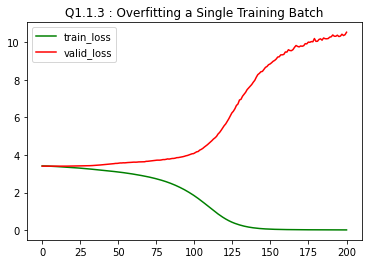

In [32]:
# ======= Single Batch Training : Plot =======
x = np.linspace(0, n_epochs, num=n_epochs)
train_loss = sb_store[0]
valid_loss = sb_store[1]
fig,ax = plt.subplots()
plt.plot(x, train_loss, 'g', label = 'train_loss')
plt.plot(x, valid_loss, 'r', label = 'valid_loss')
plt.legend()
plt.title('Q1.1.3 : Overfitting a Single Training Batch')



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [35]:
# Bug with Jupyter Notebook and Multi-Processing (hence num_workers = 1 default)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

# Re-init model instance (reset model from previous run)
model = cnn()    
# Move to device
model.cuda(device)

# Re-Init Loss and Optimizer 
loss_fn = nn.CrossEntropyLoss()                                      # CrossEntropyLoss for Loss Function
opt_fn = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Desc for optimizer

In [36]:
n_epochs = 60 # Chosen to stop before training overfitting occurs. 

# ======= Complete Batch Training =======
fb_store = np.zeros((2, n_epochs))

for epoch in range(n_epochs):
    
    # ====== Training (All Batches) 
    running_train_loss = 0.0
    n_train_batches = 0
    for i, train_data in enumerate(train_loader, 0):
        
        # Pass training batch images and labels onto device
        train_images, train_labels = train_data[0].to(device), train_data[1].to(device)
        #train_images, train_labels = train_data
        
        # Zero Grad
        opt_fn.zero_grad()
        
        # Eval network (forward, compute loss, backprop)
        train_outputs = model(train_images) 
        train_loss    = loss_fn(train_outputs, train_labels)
        train_loss.backward()
        opt_fn.step()
    
        running_train_loss += train_loss.item()
        n_train_batches += 1
        
    # ====== Validation (All Batches) 
    running_valid_loss = 0.0
    n_valid_batches = 0
    # Run over Validation set (disable gradient computation for inference)
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            # Pass validation batch Images and Labels onto device
            valid_images, valid_labels = data[0].to(device), data[1].to(device)
            
            # Eval model for validation images and compute loss
            valid_out = model(valid_images) # forward
            valid_loss = loss_fn(valid_out, valid_labels) # loss
            running_valid_loss += valid_loss.item()
            n_valid_batches += 1
            
    # Store (per epoch)
    running_valid_loss /= n_valid_batches  
    running_train_loss /= n_train_batches
    fb_store[0][epoch] = running_train_loss
    fb_store[1][epoch] = running_valid_loss
    # Print Output per epoch (training vs valid loss) every nth epoch
    if epoch % 10 == 0:
        print(f"epoch: {epoch} training_loss: {train_loss: .5f} validation_loss: {running_valid_loss: .5f}")  
        
# Save Model
torch.save(model.state_dict(), "model_q121_b.pt")           

epoch: 0 training_loss:  3.40027 validation_loss:  3.39255
epoch: 10 training_loss:  2.96177 validation_loss:  2.83386
epoch: 20 training_loss:  2.67368 validation_loss:  2.60074
epoch: 30 training_loss:  2.48666 validation_loss:  2.43100
epoch: 40 training_loss:  2.29230 validation_loss:  2.39443
epoch: 50 training_loss:  1.46011 validation_loss:  2.37798


Text(0.5, 1.0, 'Q1.2.1 : Full Training Set')

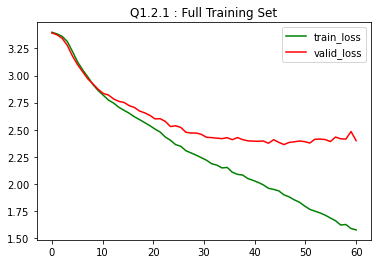

In [37]:
x = np.linspace(0, n_epochs, num=n_epochs)
train_loss = fb_store[0][:]
valid_loss = fb_store[1][:]
fig,ax = plt.subplots()
plt.plot(x, train_loss, 'g', label = 'train_loss')
plt.plot(x, valid_loss, 'r', label = 'valid_loss')
plt.legend()
plt.title('Q1.2.1 : Full Training Set')


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Set Size = 11475 | Validation Set Size = 2025
Debug::Training Loader


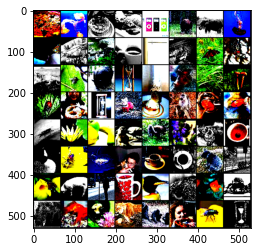

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Debug::Validation Loader


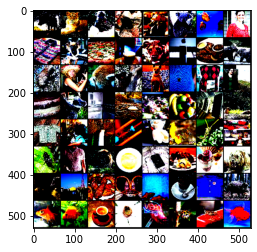

In [39]:
# Data Augmentation
# Problem : We want sepereate transforms for Training and Validation Set (ie. no augmentation transforms on validation).
# However, because randomsplit breaks transforms, we need a custom class to handle the split datasets transforms.
# See : https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4

# This class wraps around the resulting split datasets, and applies additional transforms ontop
# based on if training or validation set, thus allowing different transforms for each set. 
class SplitDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, split: str = 'train'):
        self.dataset = dataset
        self.split = split
        
        # Transforms (remove ToTensor() as this is already applied in "base_transform")
        # Training Transforms (with augmentation)
        self.transform_train = transforms.Compose(
            [transforms.Normalize(norm_mean, norm_std),
             transforms.RandomGrayscale(p=0.25),
             transforms.RandomHorizontalFlip(p=0.5)
            ])
        
        
        # Validation Transforms (no augmentation)
        self.transform_valid = transforms.Normalize(norm_mean, norm_std)
        
    def __len__(self):
        return len(self.dataset)
    
    # This applies per     
    def __getitem__(self, idx):
        # Forward call to split dataset
        x, y = self.dataset[idx]
        # Transforms of split dataset
        if self.split == 'train':
            x = self.transform_train(x)
        elif self.split == 'valid':
            x = self.transform_valid(x)
        return x, y
    


# ======== Create Datasets ========
# Base Transform (ToTensor()) to perform on dataset, before per split/susbet transforms are called. 
base_transform = transforms.ToTensor()

# Orginal Training Set
in_dataset = ImageLoader("_dataset\\train_set", transform=base_transform)
# Split into Training and Validation Set
train_size = int(0.85 * len(in_dataset))
valid_size = len(in_dataset) - train_size
print("Training Set Size = %d | Validation Set Size = %d" % (train_size, valid_size))
train_subset, valid_subset = torch.utils.data.random_split(in_dataset, [train_size, valid_size])

# Wrap subsets into my SplitDataset wrapper class
train_set = SplitDataset(train_subset, 'train')
valid_set = SplitDataset(valid_subset, 'valid')

# ======== Create DataLoaders ========
# Training, Validation Loader from wrapped susbsets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

# DEBUG : Show minibatch grid
print("Debug::Training Loader")
sample, label = iter(train_loader).next()  
timshow(make_grid(sample))
print("Debug::Validation Loader")
sample, label = iter(valid_loader).next()  
timshow(make_grid(sample))

In [40]:
# Modified CNN based on Lenet. With BatchNorm on Conv layers and Dropout on fully connected layers. 
class cnn_122(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout(0.6)
        self.drop2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2704, 512)
        self.fc2 = nn.Linear(512, 96)
        self.fc3 = nn.Linear(96, 30)
        
    def forward(self, x):
        x = self.bn1(self.pool(nn.functional.relu(self.conv1(x))))
        x = self.bn2(self.pool(nn.functional.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.drop1(self.fc1(x)))
        x = nn.functional.relu(self.drop2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [41]:
# Create new Training and Valid loaders to uitlize GPU better (large batch size)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

# Create new cnn_122 model instance
model = cnn_122()    
# Move to device
model.cuda(device)

# Re-Init Loss and Optimizer 
loss_fn = nn.CrossEntropyLoss()                                      # CrossEntropyLoss for Loss Function
opt_fn = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Desc for optimizer

In [42]:
n_epochs = 50

# ======= Complete Batch Training =======
ab_store = np.zeros((2, n_epochs))

for epoch in range(n_epochs):
    
    # ====== Training (All Batches) 
    model.train()
    running_train_loss = 0.0
    n_train_batches = 0
    for i, train_data in enumerate(train_loader, 0):
        
        # Pass training batch images and labels onto device
        train_images, train_labels = train_data[0].to(device), train_data[1].to(device)
        #train_images, train_labels = train_data # CPU
        
        # Zero Grad
        opt_fn.zero_grad()
        
        # Eval network (forward, compute loss, backprop)
        train_outputs = model(train_images) 
        train_loss    = loss_fn(train_outputs, train_labels)
        train_loss.backward()
        opt_fn.step()
    
        running_train_loss += train_loss.item()
        n_train_batches += 1
        
    # ====== Validation (All Batches) 
    model.eval() # disable pooling
    running_valid_loss = 0.0
    n_valid_batches = 0
    correct = 0
    total = 0
    # Run over Validation set (disable gradient computation for inference)
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            # Pass validation batch Images and Labels onto device
            valid_images, valid_labels = data[0].to(device), data[1].to(device)
            
            # Eval model for validation images and compute loss
            valid_out = model(valid_images) # forward
            valid_loss = loss_fn(valid_out, valid_labels) # loss
            
            _, predicted = torch.max(valid_out.data, 1)
            total += valid_labels.size(0)
            correct += (predicted == valid_labels).sum().item()
            
            running_valid_loss += valid_loss.item()
            n_valid_batches += 1
            
    # Store (per epoch)
    running_valid_loss /= n_valid_batches  
    running_train_loss /= n_train_batches
    valid_accuracy = (correct / total) * 100
    ab_store[0][epoch] = running_train_loss
    ab_store[1][epoch] = running_valid_loss
    # Print Output per epoch (training vs valid loss) every nth epoch
    if epoch % 10 == 0: 
        print(f"epoch: {epoch} training_loss: {train_loss: .5f} validation_loss: {running_valid_loss: .5f} \
        validation accuracy: {valid_accuracy: .1f} %")
    
# Save Model
torch.save(model.state_dict(), "model_q122.pt")

epoch: 0 training_loss:  3.33739 validation_loss:  3.30140         validation accuracy:  9.1 %
epoch: 10 training_loss:  2.41159 validation_loss:  2.34781         validation accuracy:  31.8 %
epoch: 20 training_loss:  2.47638 validation_loss:  2.04592         validation accuracy:  38.6 %
epoch: 30 training_loss:  2.69563 validation_loss:  1.93928         validation accuracy:  42.5 %
epoch: 40 training_loss:  1.84258 validation_loss:  1.89444         validation accuracy:  45.4 %


Text(0.5, 1.0, 'Q1.2.2 : Augmented Training')

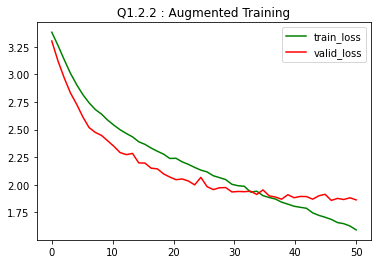

In [43]:
# Plot Model Loss
x = np.linspace(0, n_epochs, num=n_epochs)
train_loss = ab_store[0][:]
valid_loss = ab_store[1][:]
fig,ax = plt.subplots()
plt.plot(x, train_loss, 'g', label = 'train_loss')
plt.plot(x, valid_loss, 'r', label = 'valid_loss')
plt.legend()
plt.title('Q1.2.2 : Augmented Training')


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

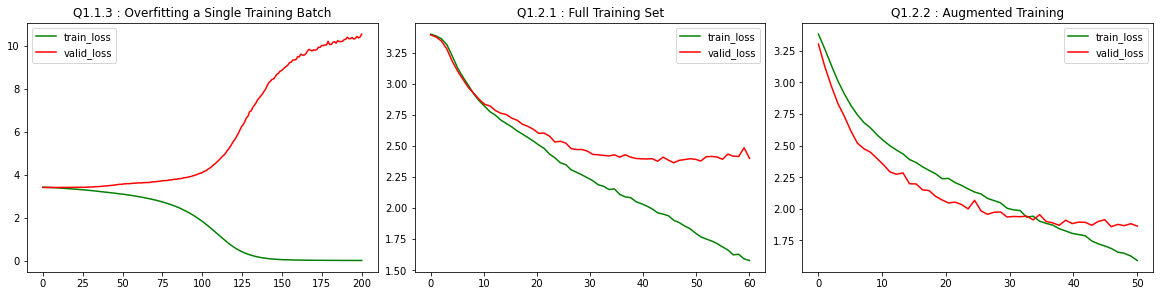

In [45]:
x_sb = np.linspace(0, 200, num=200)
x_fb = np.linspace(0, 60, num=60)
x_ab = np.linspace(0, 50, num=50)

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(16, 4))
# Single Training Batch Graph
ax[0].plot(x_sb, sb_store[0], 'g', label = 'train_loss')
ax[0].plot(x_sb, sb_store[1], 'r', label = 'valid_loss')
ax[0].legend()
ax[0].title.set_text('Q1.1.3 : Overfitting a Single Training Batch')
# Full Training Batch Graph
ax[1].plot(x_fb, fb_store[0], 'g', label = 'train_loss')
ax[1].plot(x_fb, fb_store[1], 'r', label = 'valid_loss')
ax[1].legend()
ax[1].title.set_text('Q1.2.1 : Full Training Set')
# Augmented Training Batch Graph
ax[2].plot(x_ab, ab_store[0], 'g', label = 'train_loss')
ax[2].plot(x_ab, ab_store[1], 'r', label = 'valid_loss')
ax[2].legend()
ax[2].title.set_text('Q1.2.2 : Augmented Training')

Explain what can be seen in the graphs.

**Single Training Batch Network (Q1.1.3) :** 
Validation loss on single batch doesn't decrease after the first epoch because the same training batch is used each epoch, so the model just learns how to fit the single training batch better and better, so while the training loss tends to zero, the validation loss starts to increase as the network becomes worse at generalising to the validation set. This would be expected when training a network with such little data. 

**Full Training Set Network (Q1.2.1) :**
Validation loss no longer increases quite so fast, but starts to decrease as we'd hope, as the network is able to evaluate unseen data. However it plateaus out and thus still begins to overfit eventually and thus the training epochs/iteration is truncated to avoid further overfitting (where validation loss will begin to increase). As this is the best loss we could obtain with the current network and training data, training and network augmentation is needed to try and further decrease the validation loss (while still ensuring the training loss is also minimised). 

**Augmented Network (Q1.2.2) :**
Validation loss is more synchronized with training loss, suggesting better generalisation and less over-fitting to the training set, it actually also starts slightly lower than the training loss, which may be because the data in the validation set is "easier" for the network to classify as it is not augmented like the training set. The modifications to the network (dropout on fully connected layers and batch normalisation on the convolutional layers) have enhanced performance and not hindered the networks ability to learn as the training loss still tends to zero indicating that underfitting is not a problem. The Validation Loss does begin to plateau hence why 50 epochs were used, to avoid going into overfitting. However the validation loss is minimised greater than the previous full training set network. 


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [46]:
# Init Matrices
cnfm_train = np.zeros((30, 30), dtype=int)
cnfm_valid = np.zeros((30, 30), dtype=int)

# Load Model
model = cnn_122()
model.load_state_dict(torch.load("model_q122.pt"))
model.eval()    

# Confusion Matrix : Training Set
with torch.no_grad():
    for data in train_loader:
        train_images, train_labels = data
        train_out = model(train_images) 
        _, predicted = torch.max(train_out.data, 1) # Confidence val
        
        # Accum predictions into confusion mat
        for i in range(train_labels.size(0)):
            cnfm_train[train_labels[i].item(), predicted] += 1

# Confusion Matrix : Validation Set
with torch.no_grad():
    for data in valid_loader:
        valid_images, valid_labels = data
        valid_out = model(valid_images) 
        _, predicted = torch.max(valid_out.data, 1) # Confidence val
        
        # Accum predictions into confusion mat
        for i in range(valid_labels.size(0)):
            cnfm_valid[valid_labels[i].item(), predicted] += 1

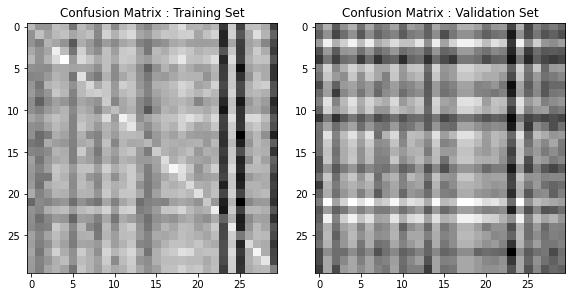

In [47]:
# Map indices back to class names
idx_to_class = dict((v, k) for k,v in class_to_idx.items())

def acc_rec_prec():
    # Compute Confusion Matrices (Accuracy, Recall, Precision)
    # Training 
    cnfm_train_acc = cnfm_train.trace() / cnfm_valid.sum((0, 1))
    cnfm_train_rec = np.diag(cnfm_train) / cnfm_valid.sum(1)
    cnfm_train_prec = np.diag(cnfm_train) / cnfm_valid.sum(0)
    # Validation
    cnfm_valid_acc = cnfm_valid.trace() / cnfm_valid.sum((0, 1))
    cnfm_valid_rec = np.diag(cnfm_valid) / cnfm_valid.sum(1)
    cnfm_valid_prec = np.diag(cnfm_valid) / cnfm_valid.sum(0)
    print("======== Training Precision and Recall ========")
    for i in range(30):
        print(f"Class {idx_to_class[i]}   Precision {cnfm_train_prec[i]: .1%} | Recall : {cnfm_train_rec[i]: .1%}")
    print("======== Validation Precision and Recall ========")
    for i in range(30):
        print(f"Class {idx_to_class[i]}   Precision {cnfm_valid_prec[i]: .1%} | Recall  {cnfm_valid_rec[i]: .1%}")

# Print per class Accuracy, Recall, Precision (for train and validation)        
#acc_rec_prec()      

# Plot Confusion Matrices
figcnfm, axcnfm = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
axcnfm[0].title.set_text('Confusion Matrix : Training Set')
axcnfm[0].imshow(cnfm_train, cmap="gray")
axcnfm[1].title.set_text('Confusion Matrix : Validation Set')
axcnfm[1].imshow(cnfm_valid, cmap="gray")

What conclusions can be drawn from the confusion matrices?

The training confusion matrix shows many more true positives for each class, given that the diagnal has a higher colour value when viewed with the gray colour map. The validation matrix been less diagonally dominant shows more error and thus false positives and false negatives have occured for each class.



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [49]:
# Dataset Loader for Test Data (hardcoded transforms, toTensor(), Normalise)
class TestLoader(torch.utils.data.Dataset):
    def __init__(self, dir):
        self.dir = dir
        self.imgs = os.listdir(self.dir)
        # Transforms for inference / test
        self.transform = transforms.Compose(
            [transforms.ToTensor(),transforms.Normalize(norm_mean, norm_std)])
        return
    
    def __len__(self):
        return len(self.imgs)
    
    # Given an index, get a random image and its name string
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(os.path.abspath(self.dir), img_name)
        image = Image.open(img_path).convert("RGB") 
        trans = self.transform(image)     
        return trans, img_name

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Debug::Testing Loader


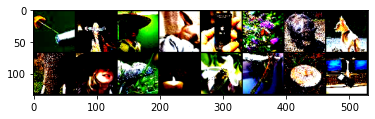

In [50]:
test_set = TestLoader("_dataset\\test_set")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)

# DEBUG : Testing Dataloader Minibatch grid
print("Debug::Testing Loader")
img, img_name = iter(test_loader).next()  
timshow(make_grid(img))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


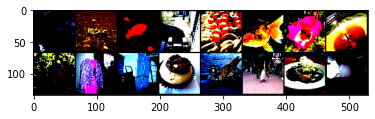

Image : c9628440_9dce.JPEG Predicted Class : bison
Image : c9704655_7452.JPEG Predicted Class : grasshopper
Image : c996766c_021a.JPEG Predicted Class : goldfish
Image : ca059d4b_796c.JPEG Predicted Class : elephant
Image : ca1b5107_fded.JPEG Predicted Class : pizza
Image : ca79d6c6_f99f.JPEG Predicted Class : pizza
Image : ca7a98fa_5e1d.JPEG Predicted Class : bee
Image : ca901818_cfd0.JPEG Predicted Class : banana
Image : caa298df_d350.JPEG Predicted Class : koala
Image : caa91c3d_5b0a.JPEG Predicted Class : cardigan
Image : caa9dd5c_b55b.JPEG Predicted Class : penguin
Image : caab1005_3260.JPEG Predicted Class : espresso
Image : cabf7653_7c55.JPEG Predicted Class : sombrero
Image : cae0e25b_6a4f.JPEG Predicted Class : pig
Image : cae3757d_068d.JPEG Predicted Class : icecream
Image : caf291b4_646f.JPEG Predicted Class : ipod


In [51]:
model = cnn_122()
model.load_state_dict(torch.load("model_q122.pt"))
model.eval()    

# Show this random batche index predicted results
view_batch = int(np.random.randint(0, high=len(test_loader)))

# Inference on CPU
predict_out = {}
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        test_images, test_names = data
        test_out = model(test_images) 
        
        # Get highest class confidence val for batch 
        _, predicted = torch.max(test_out.data, 1) 
        
        # Store per batch, image name and predicted label into dict
        for j in range(len(test_names)):
            class_str = idx_to_class[int(predicted[j])]
            pred = {test_names[j] : class_str}
            predict_out.update(pred)
          
        # Preview Predictions for a random batch
        if (i == view_batch):
            timshow(make_grid(test_images))  
            for j in range(len(test_names)):
                print(f"Image : {test_names[j]} Predicted Class : {idx_to_class[int(predicted[j])]}")
                
                
#print(len(predict_out))
#print(predict_out)


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [52]:
import csv
outfile = open('sc20ngh.csv', 'w', newline='') # prevent gaps between rows, don't use 'wb'
writer = csv.writer(outfile)
writer.writerow(['Id', 'Category']) # Header

# Write test set predictions out
for k,v in predict_out.items():
    row = [k, class_to_idx[v]] # CSV stores class indices, not str labels. 
    writer.writerow(row)

outfile.close()

In [ ]:
# Submission via call to Kaggle API tbd ... for now I uploaded manually



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [584]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\Niall/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Niall/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100.0%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.features

In [586]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [698]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [598]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    ten_ng = model.features[layer_idx].weight.detach().clone() # Remove grad
    return ten_ng

In [599]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [602]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



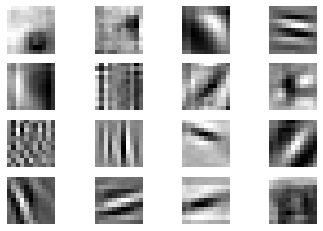

In [952]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()

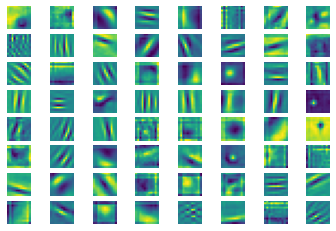

In [709]:
# Test: 0th Feaure : Show each filter [0-63], R channel, filter size (11x11). 
plt_dim = int(math.sqrt(64))
col = filters[0].numpy()
for i in range(64):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(col[i][0])
    plt.axis('off')
plt.show()     



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [644]:
# TO COMPLETE
image = Image.open('man_bike.jpeg').convert("RGB")

Run the code cell below to apply the image transformation expected by the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


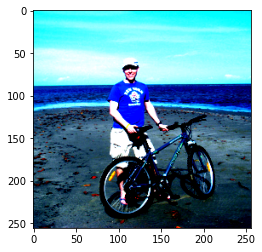

In [748]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(image)
# Test output
plt.imshow(np.transpose(im.numpy(),(1,2,0)))


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [919]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
    # Layers (0, 3, 10), get MaxPool feature idex of each (2,5,12). 
    mxp_ft_inds = [2, 5, 12] 
    
    # Forward Through Conv Layers and store feature maps
    #out = image.unsqueeze(0) # pass to next conv layer
    out = image

    # Loop through model features and store feature maps for above feature indices. 
    fm = [] 
    for i, feat in enumerate(model.features, 0):
        out = feat.forward(out)
        if (i == 2 or i == 5 or i == 12):
            fm.append(out)
    return fm

In [922]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)
#print(len(feature_maps))

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [923]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]

torch.Size([1, 64, 63, 63]) | torch.Size([1, 64, 63, 63]) | torch.Size([1, 64, 31, 31])


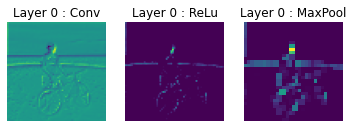

In [886]:
# TESTING ONLY (Please ignore when marking!)
# Test Manual forwarding through ConvLayer 0
# Conv --> Activation --> MaxPool --> Viz (FeatureMap 0 of each)
inpt = im.unsqueeze(0)   
fig, ax = plt.subplots(1, 3)
conv0_in  = model.features[0].forward(inpt)
ax[0].title.set_text("Layer 0 : Conv")
ax[0].imshow(conv0_in.detach()[0, 0, :, :])
ax[0].axis('off')
conv0_act = model.features[1].forward(conv0_in)
ax[1].title.set_text("Layer 0 : ReLu")
ax[1].imshow(conv0_act.detach()[0, 0, :, :])
ax[1].axis('off')
conv0_mxp = model.features[2].forward(conv0_act)
ax[2].title.set_text("Layer 0 : MaxPool")
ax[2].imshow(conv0_mxp.detach()[0, 0, :, :])
ax[2].axis('off')
print(f"{conv0_in.size()} | {conv0_act.size()} | {conv0_mxp.size()}")



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

In [945]:
plt_dim = int(math.sqrt(16))

def viz_fmap16(mp_feature):
    mp = mp_feature.detach()
    for j in range(16):
        plt.subplot(plt_dim, plt_dim, j+1)
        plt.imshow(mp[0, j, :, :])
        plt.axis('off')

ConvLayer 0 MaxPool (feature 2) : Feature Maps


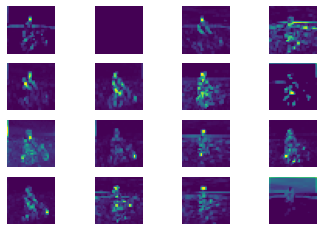

In [946]:
print("ConvLayer 0 MaxPool (feature 2) : Feature Maps")
viz_fmap16(feature_maps[0])

ConvLayer 1 MaxPool (feature 5) : Feature Maps


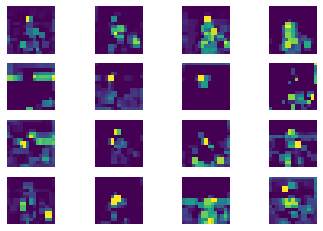

In [947]:
print("ConvLayer 1 MaxPool (feature 5) : Feature Maps")
viz_fmap16(feature_maps[1])   

ConvLayer 4 MaxPool (feature 12) : Feature Maps


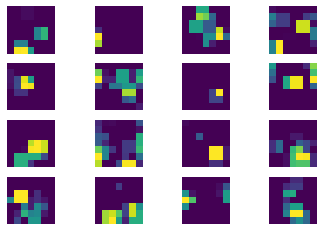

In [948]:
print("ConvLayer 4 MaxPool (feature 12) : Feature Maps")
viz_fmap16(feature_maps[2])




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


**Index 0:** Shows edges, which can be seen looking at the feature map 0 of ConvLayer 0. 

**Index 4:** Shows vertical lines, which can be seen looking at the feature map 4 of ConvLayer 0, arms captured. 

**Index 6:** Shows horiztonal lines, which can be seen looking at the feature map 6 of ConvLayer 0, eg terrain/grass captured. 

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.

Their resolution gets coarser and their more of the weights appear to have higher scalar values as they begin to learn the relveant activations needed within the kernel. 

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

Their resolution gets coarser also (from max pooling) and they start to resemble areas of the input that resmeble visual cues / segmented features of the orginal image, becoming less abstract. 


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [1070]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition 
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [1145]:
model = alexnet(pretrained=True)
model.eval() # Put in eval mode for inference

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [1425]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))
# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

##### NOTE : For ImageNet Class Indices I'm using this reference : 
**imagenet1000_clsidx_to_labels.txt  - https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a**

I'm Manually indexing these indices --> class labels, oppose to using a dict, to avoid using external code. 

In [1426]:
print(f"{output.size()} {pred_cls.size()}\n")
print(f"Predicted Class Index = {int(pred_cls[0,0])}")
# Class id 444: 'bicycle-built-for-two, tandem bicycle, tandem'.
# Note : It also showed Class id 880, before model was set to model.eval()

torch.Size([1, 1000]) torch.Size([1, 1])

Predicted Class Index = 444


### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [1427]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    
    output[:, class_id].backward()
    
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    gradients = model.gradients
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    activations = model.get_activations(image)
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # TEST
    #plt.imshow(activations[0, 0, :, :].detach() * pooled_gradients[0])

    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    heatmap = np.maximum(heatmap.detach(), 0)
    # normalise (probs not needed)
    heatmap /= torch.max(heatmap)
    
    return heatmap

In [1428]:
output = model(im.unsqueeze(0)) # recall forward on model first to get output.
_, pred_cls = output.max(dim=1, keepdim=True)

# Gen Heatmap
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

Heatmap Size : torch.Size([7, 7]), Preview :


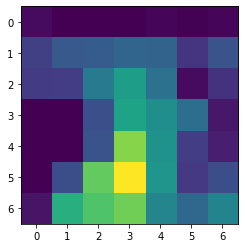

In [1429]:
print(f"Heatmap Size : {heatmap.size()}, Preview :") # Same dim as featuremap output 7x7
plt.imshow(heatmap.detach())
#print(heatmap)

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

(-0.5, 255.5, 255.5, -0.5)

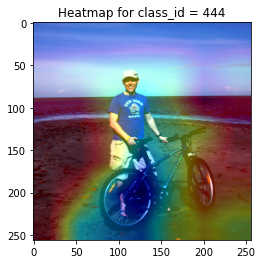

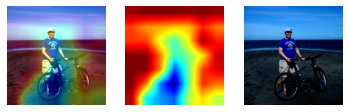

In [1431]:
# TO COMPLETE
# Image Prep
# Normalise and map to integer (0-255)
im_in = np.transpose(im.numpy(),(1,2,0)) # Convert image to numpy array and transpose dims. 
im_in = im_in - im_in.min()
im_in = im_in / im_in.max() * 255
im_t = np.uint8(im_in) 

# Heatmap Prep
heatmap_rs = cv2.resize(heatmap.numpy(), (256, 256))         # rescale heatmap tensor (to cv2 img via numpy.() array)
heatmap_rs = np.uint8(255 * heatmap_rs)                      # map to 0-255 int range
heatmap_rs = cv2.applyColorMap(heatmap_rs, cv2.COLORMAP_JET) # apply colormap
heatmap_ref = heatmap_rs

# Mult by 0.4
heatmap_rs = heatmap_rs * 0.4         # reduce col sat
heatmap_rs = heatmap_rs.astype('uint8') # back to uint

# Composite Heatmap onto Image
# Use cv2.add for saturated add oppose to numpy add
comp = cv2.add(heatmap_rs, im_t) 

# Map to 0-255 range
out = cv2.normalize(comp, comp, 0, 255, cv2.NORM_MINMAX)

# Output
plt.imshow(out)
plt.title(f"Heatmap for class_id = {int(pred_cls)}")
# Subplot
fig, ax = plt.subplots(1, 3)
ax[0].imshow(out)
ax[0].axis('off')
ax[1].imshow(heatmap_ref)
ax[1].axis('off')
ax[2].imshow(im_t)
ax[2].axis('off')

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

(-0.5, 255.5, 255.5, -0.5)

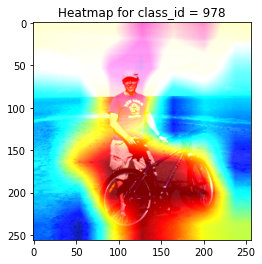

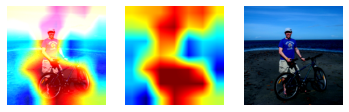

In [1432]:
# Gen Heatmap for class_id = 978
output = model(im.unsqueeze(0)) # recall forward on model first to get output.
heatmap_b = generate_heatmap(output, 978, model, im.unsqueeze(0))

# ToDo : warp into function
# Heatmap Prep
heatmap_b_rs = cv2.resize(heatmap_b.numpy(), (256, 256))         # rescale heatmap tensor (to cv2 img via numpy.() array)
heatmap_b_rs = np.uint8(255 * heatmap_b_rs)                      # map to 0-255 int range
heatmap_b_rs = cv2.applyColorMap(heatmap_b_rs, cv2.COLORMAP_JET) # apply colormap
heatmap_b_ref = heatmap_b_rs

# Mult by 0.4
heatmap_rs_b = heatmap_b_rs * 0.4           # reduce col sat
heatmap_rs_b = heatmap_b_rs.astype('uint8') # back to uint

# Composite Heatmap onto Image
# Use cv2.add for saturated add oppose to numpy add
comp = cv2.add(heatmap_rs_b, im_t) 

# Map to 0-255 range
out = cv2.normalize(comp, comp, 0, 255, cv2.NORM_MINMAX)

# Output
plt.imshow(out)
plt.title("Heatmap for class_id = 978")
fig, ax = plt.subplots(1, 3)
# Subplot
ax[0].imshow(out)
ax[0].axis('off')
ax[1].imshow(heatmap_b_ref)
ax[1].axis('off')
ax[2].imshow(im_t)
ax[2].axis('off')

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

Prediction = 946


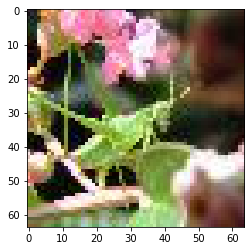

In [1435]:
# Load Grasshopper Image (grasshopper.jpeg == n02226429_34.JPEG)
test_image = Image.open('grasshopper.jpeg').convert("RGB")
plt.imshow(test_image)
# Transforms
test_im = data_transform(test_image)
# Inference
test_output = model(test_im.unsqueeze(0))
# Prediction
_, pred_cls = test_output.max(dim=1, keepdim=True)
print(f"Prediction = {int(pred_cls[0])}")

In [1436]:
# 946: 'cardoon', ImageNet Class Index source : https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# Image is actually grasshopper from imagenet (and tinyimagenet30) n02226429_34.JPEG
# Grass hopper class index is 311.

(-0.5, 255.5, 255.5, -0.5)

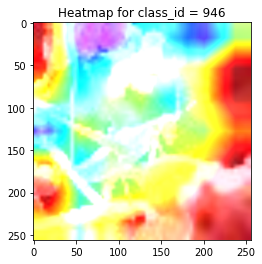

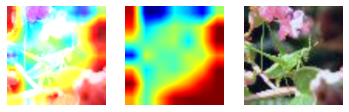

In [1437]:
# Gen Heatmap
test_heatmap = generate_heatmap(test_output, pred_cls, model, test_im.unsqueeze(0))

# Normalise
ghop_t = np.transpose(test_im.numpy(),(1,2,0)) # Convert image to numpy array and transpose dims. 
ghop_t = ghop_t - ghop_t.min()
ghop_t = ghop_t / ghop_t.max() * 255
ghop_img = np.uint8(ghop_t)

# ToDo : warp into function
# Heatmap Prep
heatmap_c_rs = cv2.resize(test_heatmap.numpy(), (256, 256))         # rescale heatmap tensor (to cv2 img via numpy.() array)
heatmap_c_rs = np.uint8(255 * heatmap_c_rs)                      # map to 0-255 int range
heatmap_c_rs = cv2.applyColorMap(heatmap_c_rs, cv2.COLORMAP_JET) # apply colormap
heatmap_c_ref = heatmap_c_rs

# Mult by 0.4
heatmap_rs_c = heatmap_c_rs * 0.4           # reduce col sat
heatmap_rs_c = heatmap_c_rs.astype('uint8') # back to uint

# Composite Heatmap onto Image
# Use cv2.add for saturated add oppose to numpy add
comp = cv2.add(heatmap_rs_c, ghop_img) 

# Map to 0-255 range
out = cv2.normalize(comp, comp, 0, 255, cv2.NORM_MINMAX)

# Output
plt.imshow(out)
plt.title("Heatmap for class_id = 946")
fig, ax = plt.subplots(1, 3)
ax[0].imshow(out)
ax[0].axis('off')
plt.imshow(test_heatmap.detach())
ax[1].imshow(heatmap_c_ref)
ax[1].axis('off')
ax[2].imshow(ghop_img)
ax[2].axis('off')

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

It seems the model has viewed the flower on the bottom right of the image has having highest "importance"/weighting and used this to classify incorrectly as a 'cardoon' (imagenet class_idx 946) oppose to the image's actual class of the 'grasshopper' (imagenet class_idx 311). 

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
